In [17]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

# mlp model

In [18]:
class MLPModel(nn.Module):
  def __init__(self, dim=128, num_tokens=97, max_norm=None, use_norm_layer=False):
    """
    from the physics paper
      The basic setup is as follows: our model takes as input the symbols a, b and
      maps them to trainable embedding vectors Ea, Eb ∈ Rdin . It then sums Ea, Eb and sends the resulting
      vector through a “decoder” MLP. The target output vector, denoted Yc ∈ Rdout is a fixed random
      vector (regression task) or a one-hot vector (classification task).
    """
    super().__init__()
    self.use_norm_layer = use_norm_layer
    self.embedding_norm = nn.LayerNorm(dim) 
    # token_embeddings map integer tokens 0...p-1 to embeddings of size dim
    self.token_embeddings = nn.Embedding(num_tokens, dim, max_norm=max_norm)
    # decoder is a MLP
    self.decoder = nn.Sequential(
      nn.Linear(dim, 200),
      nn.ReLU(),
      nn.Linear(200, dim),
      nn.ReLU(),
    )
    self.head = nn.Linear(dim, num_tokens)

    # norms of the initialized layers
    self.token_weights_initial = torch.norm(self.token_embeddings.weight).item()
    # self.decoder_l1_weights_initial = torch.norm(self.decoder[0].weight).item()
    # self.decoder_l2_weights_initial = torch.norm(self.decoder[2].weight).item()
    # self.head_weights_initial = torch.norm(self.head.weight).item()

  def forward(self, x1, x2):
    h1 = self.token_embeddings(x1)
    h2 = self.token_embeddings(x2)

    # embedding_norm only used when use_norm_layer is true
    if self.use_norm_layer:
      h = self.embedding_norm(h1) + self.embedding_norm(h2)
    else:
      h = h1 + h2
    x = self.decoder(h)
    return self.head(x)

  def normalize(self):
    """
    trying to replicate the results from omnigrok by normalizing the weights
    """
    self.token_embeddings.weight = nn.Parameter(self.token_embeddings.weight * (self.token_weights_initial / torch.norm(self.token_embeddings.weight).item()))
    # self.decoder[0].weight = nn.Parameter(self.decoder[0].weight * (self.decoder_l1_weights_initial / torch.norm(self.decoder[0].weight).item()))
    # self.decoder[2].weight = nn.Parameter(self.decoder[2].weight * (self.decoder_l2_weights_initial / torch.norm(self.decoder[2].weight).item()))
    # self.head.weight = nn.Parameter(self.head.weight * (self.head_weights_initial / torch.norm(self.head.weight).item()))


In [19]:
def mod_p_data(p, operations=["addition"]):
  """
  create the algorithmic dataset
  input:
    p - prime number
    operations - list of operations 
  returns:
    2 + len(operations) by p^2//2 matrix where the first row is x, second row is y, nth row after is the 
    operation in operations applied to x, y (in order)
    example:
      p = 3, operation = ["addition", "multiplication"] returns
        tensor([[0, 0, 0, 1, 1, 2],
                [0, 1, 2, 1, 2, 2],
                [0, 1, 2, 2, 0, 1],
                [0, 0, 0, 1, 2, 1]])
  """
  x = []
  y = []
  result = []

  for i in range(p):
    for j in range(i, p):
      x.append(i)
      y.append(j)
      result_i = []
      for operation in operations:
        if operation == "multiplication":
          result_i.append((i * j) % p)
        elif operation == "addition":
          result_i.append((i + j) % p)
        elif operation == "squared_sum":
          result_i.append((i**2 + j**2) % p)
        elif operation == "x^2+xy+y^2":
          result_i.append((i**2 + i*j + j**2) % p)
      result.append(result_i)

  return torch.concat([torch.tensor(x).unsqueeze(dim=-1).T, torch.tensor(y).unsqueeze(dim=-1).T, torch.tensor(result).T])

In [20]:
import itertools
def getAdditionPairs(p):
  """
  returns set of tuple pairs ((a_1, b_1), (a_2, b_2)) such that (a_1 + b_1) mod p = (a_2 + b_2) mod p
  for all 0 <= a_i, b_i <= p - 1
    example, (p = 3):
      {((0, 0), (1, 2)),
      ((0, 0), (2, 1)),
      ((0, 1), (1, 0)),
      ((0, 1), (2, 2)),
      ((0, 2), (1, 1)),
      ((0, 2), (2, 0)),
      ((1, 0), (2, 2)),
      ((1, 1), (2, 0)),
      ((1, 2), (2, 1))}
  """
  x, y = torch.arange(p), torch.arange(p)
  x, y = torch.cartesian_prod(x, y).T
  result = (x + y) % p
  result_to_pair = {}
  for i in range(len(result)):
    pair = (x[i].item(), y[i].item())
    if result[i].item() in result_to_pair:
      result_to_pair[result[i].item()].append(pair)
    else: 
      result_to_pair[result[i].item()] = [pair]
  
  pairs = set()
  for s in result_to_pair.keys():
    pairs = pairs.union(set(itertools.combinations(result_to_pair[s], 2)))
  
  return pairs

def RQI(embeddings, args, pairs):
  """
  returns RQI value defined in physics paper
  P (R, δ) = {(i, j, m, n)|(i, j, m, n) ∈ P0, |(Ei + Ej ) − (Em + En)| ≤ δ}
  input:
    embeddings - embeddings weights in model
    args - training regime args, must specify delta
    pairs - pairs to check (can use getAdditionPairs for addition operation)
  """
  P_zero = len(pairs)
  P_R = 0
  for pair in pairs:
    if torch.norm(embeddings[pair[0][0],:] + embeddings[pair[0][1]] - (
        embeddings[pair[1][0],:] + embeddings[pair[1][1]]
    )) < args.delta: 
      P_R += 1
  return P_R / P_zero

In [21]:
getAdditionPairs(3)

{((0, 0), (1, 2)),
 ((0, 0), (2, 1)),
 ((0, 1), (1, 0)),
 ((0, 1), (2, 2)),
 ((0, 2), (1, 1)),
 ((0, 2), (2, 0)),
 ((1, 0), (2, 2)),
 ((1, 1), (2, 0)),
 ((1, 2), (2, 1))}

In [22]:
def main(args, model, device, operations, train_data_pct=0.5):
  """
  main function used for training and validation
  includes a lot of data recording and plotting
  """
  # "We train on the binary operation of division mod 97 with 50% of the data
  # in the training set."
  model.token_embeddings.state_dict()['weight']
  data = mod_p_data(args.p, operations)
  randomized_indices = torch.randperm(data.shape[1])
  num_training_examples = int(data.shape[1]*train_data_pct)
  print(f'training on {num_training_examples} out of {data.shape[1]} examples')
  train_idx, valid_idx = randomized_indices[:num_training_examples], randomized_indices[num_training_examples + 1:]
  train_data, valid_data = data[:, train_idx], data[:, valid_idx]

  optimizer = getattr(torch.optim, args.optimizer)(
      model.parameters(),
      lr=args.lr,
      weight_decay=args.weight_decay,
  )

  steps_per_epoch = math.ceil(train_data.shape[1] / args.batch_size)

  # measure the accuracies and losses throughout training
  train_acc, val_acc, train_loss, val_loss = [], [], [], []
  # measure the accuracies at steps which measure RQI's, so we can plot on same axis
  train_acc_2, val_acc_2 = [], []

  # measure the norms of different layers of model
  embedding_norm = []
  last_layer_norm = []
  layer_1_norm = []
  layer_2_norm = []

  # measure the # of steps till memorization, generalization, as well as steps in between
  steps_till_perfect_training = None
  steps_till_perfect_validation = None
  difference_in_steps = None

  # measure rqi, note that a single rqi measurement takes a lot of computation
  rqi = []
  pairs = getAdditionPairs(args.p)
  all_losses = []

  for e in tqdm(range(int(args.budget) // steps_per_epoch)):
    # randomly shuffle train data
    train_data = train_data[:, torch.randperm(train_data.shape[1])]
    epoch_losses = []

    for data, is_train in [(train_data, True), (valid_data, False)]:
        model.train(is_train)
        total_loss = 0
        total_acc = 0

        # torch.split faster than dataloader with tensor
        dl = torch.split(data, args.batch_size, dim=1)
        for input in dl:
            input = input.to(device)

            with torch.set_grad_enabled(is_train):
                logits = model(input[0], input[1])
                # calculate loss (cross entropy) only on the answer part of the equation (last element)
                if (not is_train):
                  loss = F.cross_entropy(logits, input[-1])
                else:
                  individual_losses = F.cross_entropy(logits, input[-1], reduction="none")
                  epoch_losses.append(individual_losses)
                  loss = individual_losses.mean()
                total_loss += loss.item() * input.shape[-1]

            if is_train:
                model.zero_grad()
                loss.backward()
                optimizer.step()
                if args.const_norm:
                  model.normalize()

            acc = (logits.argmax(-1) == input[-1]).float().mean()
            total_acc += acc.item() * input.shape[-1]

        if is_train:
            training_acc = total_acc / train_data.shape[-1]
            train_acc.append(training_acc)
            if steps_till_perfect_training == None and round(training_acc, 6) == 1.0:
              steps_till_perfect_training = len(train_acc) * steps_per_epoch
              print(f"took {steps_till_perfect_training} steps to reach perfect training accuracy")
            train_loss.append(total_loss / train_data.shape[-1])
            embedding_norm.append(torch.norm(model.token_embeddings.weight.cpu()).item())
            last_layer_norm.append(torch.norm(model.head.weight.cpu()).item())
            layer_1_norm.append(torch.norm(model.decoder[0].weight.cpu()).item())
            layer_2_norm.append(torch.norm(model.decoder[2].weight.cpu()).item())
            all_losses.append(torch.concat(epoch_losses))

        else:
            validation_acc = total_acc / valid_data.shape[-1]
            val_acc.append(validation_acc)
            if steps_till_perfect_validation == None and round(validation_acc, 6) == 1.0:
              steps_till_perfect_validation = len(val_acc) * steps_per_epoch
              print(f"took {steps_till_perfect_validation} steps to reach perfect validation accuracy")
            val_loss.append(total_loss / valid_data.shape[-1])
        if steps_till_perfect_training != None and steps_till_perfect_validation != None and difference_in_steps == None:
          difference_in_steps = steps_till_perfect_validation - steps_till_perfect_training
        
    # rqi graph, only measured/shown when args.measure_rqi = True
    if e % args.measure_rqi_rate == 0 and args.measure_rqi:
      rqi_i = RQI(model.token_embeddings.state_dict()['weight'], args, pairs)
      rqi.append(rqi_i)
      train_acc_2.append(train_acc[-1])
      val_acc_2.append(val_acc[-1])
      steps = torch.arange(len(rqi)).numpy() * args.measure_rqi_rate * steps_per_epoch
      plt.plot(steps, rqi, label="rqi")
      plt.plot(steps, train_acc_2, label="train")
      plt.plot(steps, val_acc_2, label="val")
      plt.legend()
      plt.title(f"weight decay {args.weight_decay}, max_norm {args.max_norm}")
      plt.xlabel("Steps")
      plt.ylabel("RQI")
      plt.xscale("log")
      plt.savefig("rqi.png", dpi=150)
      plt.close()
        
    if (e + 1) % 100 == 0:
      steps = torch.arange(len(train_acc)).numpy() * steps_per_epoch
      plt.plot(steps, train_acc, label="train")
      plt.plot(steps, val_acc, label="val")
      plt.legend()
      plt.title(f"weight decay {args.weight_decay}, max_norm {args.max_norm}, val-train steps {difference_in_steps}")
      plt.xlabel("Optimization Steps")
      plt.ylabel("Accuracy")
      plt.xscale("log")
      plt.savefig("acc.png", dpi=150)
      plt.close()

      plt.plot(steps, train_loss, label="train")
      plt.plot(steps, val_loss, label="val")
      plt.legend()
      plt.title(f"weight decay {args.weight_decay}, max_norm {args.max_norm}")
      plt.xlabel("Optimization Steps")
      plt.ylabel("Loss")
      plt.xscale("log")
      plt.savefig("loss.png", dpi=150)
      plt.close()

      # plot the train and validation loss (normalized) with validation accuracy
      max_train_val_loss = max(max(max(val_loss), max(train_loss)), 1)
      plt.plot(steps, val_acc , label="accuracy")
      plt.plot(steps, [loss_i/max_train_val_loss for loss_i in val_loss], label="val_loss_normalized")
      plt.plot(steps, [loss_i/max_train_val_loss for loss_i in train_loss], label="train_loss_normalized")
      plt.legend()
      plt.title(f"loss & validation acc, weight decay {args.weight_decay}, max_norm {args.max_norm}")
      plt.xlabel("Optimization Steps")
      plt.ylabel("%")
      plt.xscale("log")
      plt.savefig("val_loss_acc.png", dpi=150)
      plt.close()

      # plot the norm of model layers
      plt.plot(steps, embedding_norm, label="embedding")
      plt.plot(steps, last_layer_norm, label="last_layer")
      plt.plot(steps, layer_1_norm, label="layer_1")
      plt.plot(steps, layer_2_norm, label="layer_2")
      plt.legend()
      plt.title(f"weight decay {args.weight_decay}, max_norm {args.max_norm}")
      plt.xlabel("Optimization Steps")
      plt.ylabel("Norm")
      plt.xscale("log")
      plt.savefig("norm.png", dpi=150)
      plt.close()
  if difference_in_steps != None:
    print(f"took {difference_in_steps} steps from perfect training to perfect accuracy")
  return all_losses

In [23]:
class Args:
    p = 97
    budget = 1e4
    batch_size = 512
    lr = 1e-3
    weight_decay = 0.002
    optimizer = 'Adam'

    # rqi
    measure_rqi = False
    measure_rqi_rate = 100
    delta = 5

    # normalization
    # const_norm is based on omnigrok paper, normalizes the embedding layer after every optim step
    const_norm = False
    # use_norm_layer adds a norm_layer after embedding layer
    use_norm_layer = False
    # max_norm constrains the max_norm of the embedding layer (based on pytorch implementation), to eliminate set to None
    max_norm = 2

args = Args()

torch.manual_seed(5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
model = MLPModel(
    dim=128, num_tokens=args.p, max_norm=args.max_norm, use_norm_layer=args.use_norm_layer
).to(device)

all_losses = main(args, model, device, ['addition'], 0.5)

training on 2376 out of 4753 examples


 32%|███▏      | 631/2000 [00:24<00:44, 31.03it/s]

took 3120 steps to reach perfect training accuracy


100%|██████████| 2000/2000 [01:08<00:00, 29.10it/s]


there are 97 embeddings with size 128


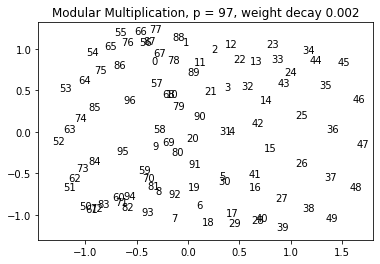

In [25]:
torch.save(model.state_dict(), 'model')
torch.save(model.token_embeddings.state_dict(), 'embeddings')
embeddings = torch.load('embeddings')
print(f"there are {embeddings['weight'].shape[0]} embeddings with size {embeddings['weight'].shape[1]}")
pca = PCA(n_components=2)
components = pca.fit_transform(embeddings['weight'].cpu().numpy())
multiplier = 1.1
plt.xlim((min(components[:args.p,0])*multiplier, max(components[:args.p,0])*multiplier))
plt.ylim((min(components[:args.p,1])*multiplier, max(components[:args.p,1])*multiplier))
for i in range(args.p):
  plt.annotate(i, (components[i,0], components[i,1]))
plt.title(f"Modular Multiplication, p = {args.p}, weight decay {args.weight_decay}")
plt.show()

# loss of individual samples

In [26]:
losses = torch.vstack(all_losses).cpu().detach().numpy()

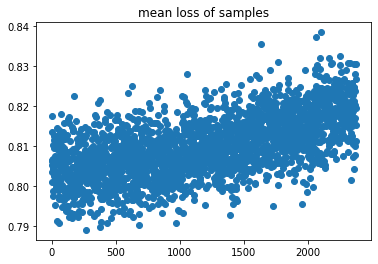

In [27]:
loss_means = losses.mean(axis=0)
plt.title("mean loss of samples")
plt.scatter(torch.arange(loss_means.shape[0]), loss_means)

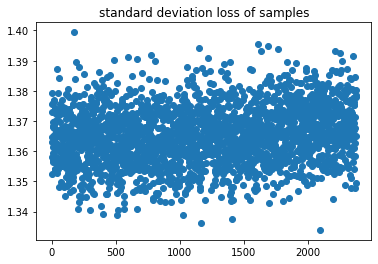

In [28]:
loss_stds = losses.std(axis=0)
plt.title("standard deviation loss of samples")
plt.scatter(torch.arange(loss_stds.shape[0]), loss_stds)

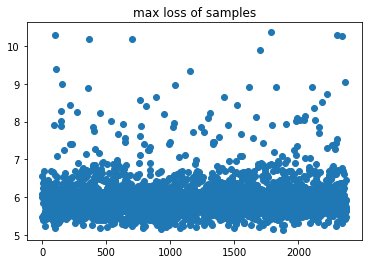

In [29]:
loss_maxes = losses.max(axis=0)
plt.title("max loss of samples")
plt.scatter(torch.arange(loss_maxes.shape[0]), loss_maxes)

# multi-head operation
- single embedding layer followed by multiple decoders trained on different operations

In [ ]:
class ModelMultiHead(nn.Module):
  def __init__(self, dim=128, num_tokens=97, max_norm=None):
    super().__init__()
    self.token_embeddings = nn.Embedding(num_tokens, dim, max_norm=max_norm)
    self.decoder_1 = nn.Sequential(
        nn.Linear(dim, 200),
        nn.ReLU(),
        nn.Linear(200, dim),
        nn.ReLU(),
    )
    self.decoder_2 = nn.Sequential(
        nn.Linear(dim, 200),
        nn.ReLU(),
        nn.Linear(200, dim),
        nn.ReLU(),
    )
    self.head_1 = nn.Linear(dim, num_tokens)
    self.head_2 = nn.Linear(dim, num_tokens)

  def forward(self, x1, x2):
    h1 = self.token_embeddings(x1)
    h2 = self.token_embeddings(x2)

    h = h1 + h2
    x_1 = self.decoder_1(h)
    x_2 = self.decoder_2(h)
    return self.head_1(x_1), self.head_2(x_2)

In [ ]:
def main2(args, model, device):
  # "We train on the binary operation of division mod 97 with 50% of the data
  # in the training set."
  data = mod_p_data(args.p, ["multiplication", "addition"])
  train_idx, valid_idx = torch.randperm(data.shape[1]).split(data.shape[1] // 2)[:2]
  train_data, valid_data = data[:, train_idx], data[:, valid_idx]

  # For most experiments we used AdamW optimizer with learning rate 10−3,
  # weight decay 1, β1 = 0.9, β2 = 0.98
  optimizer = getattr(torch.optim, args.optimizer)(
      model.parameters(),
      lr=args.lr,
      weight_decay=args.weight_decay,
  )

  steps_per_epoch = math.ceil(train_data.shape[1] / args.batch_size)

  add_train_acc, add_val_acc, add_train_loss, add_val_loss = [], [], [], []
  mult_train_acc, mult_val_acc, mult_train_loss, mult_val_loss = [], [], [], []

  embedding_norm = []

  for e in tqdm(range(int(args.budget) // steps_per_epoch)):

    # randomly shuffle train data
    train_data = train_data[:, torch.randperm(train_data.shape[1])]
    epoch_losses = []

    for data, is_train in [(train_data, True), (valid_data, False)]:

        model.train(is_train)
        add_total_loss = 0
        add_total_acc = 0
        mult_total_loss = 0
        mult_total_acc = 0

        # torch.split faster than dataloader with tensor
        dl = torch.split(data, args.batch_size, dim=1)
        for input in dl:
            input = input.to(device)

            with torch.set_grad_enabled(is_train):
                logits_add, logits_mult = model(input[0], input[1])
                loss_add = F.cross_entropy(logits_add, input[-1]) # addition
                loss_mult = F.cross_entropy(logits_mult, input[-2]) # multiplication
                add_total_loss += loss_add.item() * input.shape[-1]
                mult_total_loss += loss_mult.item() * input.shape[-1]

            if is_train:
                model.zero_grad()
                loss_add.backward(retain_graph=True)
                loss_mult.backward()
                optimizer.step()

            add_acc = (logits_add.argmax(-1) == input[-1]).float().mean()
            mult_acc = (logits_mult.argmax(-1) == input[-2]).float().mean()
            # wrong_index = ((logits.argmax(-1) != input[-1]) == True).nonzero(as_tuple=True)[0]
            # print(f"wrong index, {wrong_index}")
            add_total_acc += add_acc.item() * input.shape[-1]
            mult_total_acc += mult_acc.item() * input.shape[-1]

        if is_train:
            add_train_acc.append(add_total_acc / train_data.shape[-1])
            add_train_loss.append(add_total_loss / train_data.shape[-1])
            mult_train_acc.append(mult_total_acc / train_data.shape[-1])
            mult_train_loss.append(mult_total_loss / train_data.shape[-1])
        else:
            add_val_acc.append(add_total_acc / valid_data.shape[-1])
            add_val_loss.append(add_total_loss / valid_data.shape[-1])
            mult_val_acc.append(mult_total_acc / valid_data.shape[-1])
            mult_val_loss.append(mult_total_loss / valid_data.shape[-1])
      
        
    if (e + 1) % 100 == 0:
      steps = torch.arange(len(add_train_acc)).numpy() * steps_per_epoch
      plt.plot(steps, add_train_acc, label="add_train")
      plt.plot(steps, mult_train_acc, label="mult_train")
      plt.plot(steps, add_val_acc, label="add_val")
      plt.plot(steps, mult_val_acc, label="mult_val")
      plt.legend()
      plt.title(f"weight decay {args.weight_decay}, max_norm {args.max_norm}")
      plt.xlabel("Optimization Steps")
      plt.ylabel("Accuracy")
      plt.xscale("log")
      plt.savefig("acc.png", dpi=150)
      plt.close()

      plt.plot(steps, add_train_loss, label="add_train")
      plt.plot(steps, mult_train_loss, label="mult_train")
      plt.plot(steps, add_val_loss, label="add_val")
      plt.plot(steps, mult_val_loss, label="mult_val")
      plt.legend()
      plt.title(f"weight decay {args.weight_decay}, max_norm {args.max_norm}")
      plt.xlabel("Optimization Steps")
      plt.ylabel("Loss")
      plt.xscale("log")
      plt.savefig("loss.png", dpi=150)
      plt.close()

In [ ]:
model = ModelMultiHead(
    dim=128, num_tokens=args.p, max_norm=args.max_norm
).to(device)

main2(args, model, device)